# **1. Install librairies**

In [11]:
!pip install sentence_transformers
!pip install umap-learn

# **2. Import librairies**

In [12]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import Birch, KMeans
import joblib

# **3. Dimensionality reduction**

In [13]:
def dim_red(mat, p):
    '''
    Perform dimensionality reduction

    Input:
    -----
        mat : NxM list
        p : number of dimensions to keep
    Output:
    ------
        red_mat : NxP list such that p<<m
    '''
    model = PCA(n_components=p)
    red_mat = model.fit_transform(mat)

    return red_mat

# **4. Model building**

### **4.1. Kmeans**

In [14]:
def clust_kmeans(params, mat, k):
    '''
    Perform clustering using KMeans

    Input:
    -----
        params: dictionary containing hyperparameters for KMeans
        mat : input list
        k : number of clusters
    Output:
    ------
        pred : list of predicted labels
    '''
    kmeans = KMeans(n_clusters=k, **params)
    pred = kmeans.fit_predict(mat)

    return pred

### **4.2. Birch**

In [15]:
def clust_Birch(params, mat, k):
    '''
    Perform clustering

    Input:
    -----
        mat : input list
        k : number of clusters
    Output:
    ------
        pred : list of predicted labels
    '''
    brc = Birch(n_clusters = k, **params)
    pred = brc.fit_predict(mat)

    return pred

# **5. Word embedding**

In [16]:
# import data
ng20 = fetch_20newsgroups(subset='test')
corpus = ng20.data[:2000]
labels = ng20.target[:2000]
k = len(set(labels))

In [17]:
# embedding
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(corpus)

# **6. Start training**

In [18]:
import random

# Perform dimensionality reduction and clustering for each method
clusts = ['KMeans', "Birch"]
for clust in clusts:
# Perform dimensionality reduction
    red_emb = dim_red(embeddings, 20)

    if clust == 'KMeans':
      # define hyperparameter search space
      param_search = {
          'init': ['k-means++', 'random'],
          'n_init': [10, 20, 40, 50],
          'max_iter': [150, 200, 250, 300, 350, 400, 450]
      }

      # create a KMeans instance
      kmeans = KMeans()

      # set up RandomizedSearchCV
      random_search = RandomizedSearchCV(kmeans, param_search, cv = 3)

      # fit the grid search model
      random_search.fit(red_emb)

      # get the best hyperparameters
      best_params = random_search.best_params_

      # Perform clustering
      kmeans_cluster = clust_kmeans(best_params, red_emb, k)

      # Save the KMeans model
      joblib.dump(kmeans, 'kmeans_PCA_model.joblib')

      # Evaluate clustering results
      nmi_score = normalized_mutual_info_score(kmeans_cluster, labels)
      ari_score = adjusted_rand_score(kmeans_cluster, labels)

    if clust == 'Birch':
      # define hyperparameter search space
      param_search = {
          'threshold': [random.uniform(0.01, 0.5) for i in range(20)],
          'branching_factor': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
      }

      # create a KMeans instance
      birch = Birch()

      # set up RandomizedSearchCV
      random_search = RandomizedSearchCV(birch, param_search, scoring='neg_mean_squared_error', cv = 3)

      # fit the grid search model
      random_search.fit(red_emb)

      # get the best hyperparameters
      best_params = random_search.best_params_

      # Perform clustering
      Birch_cluster = clust_Birch(best_params, red_emb, k)

      # Save the Birch model
      joblib.dump(birch, 'birch_PCA_model.joblib')

      # Evaluate clustering results
      nmi_score = normalized_mutual_info_score(Birch_cluster, labels)
      ari_score = adjusted_rand_score(Birch_cluster, labels)

    # Print results
    print(f'Method: {clust}\nNMI: {nmi_score:.2f} \nARI: {ari_score:.2f}\n')

Method: KMeans
NMI: 0.41 
ARI: 0.23



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

Method: Birch
NMI: 0.38 
ARI: 0.19



# **7. Visualization**

### **7.1. Kmeans visualization**

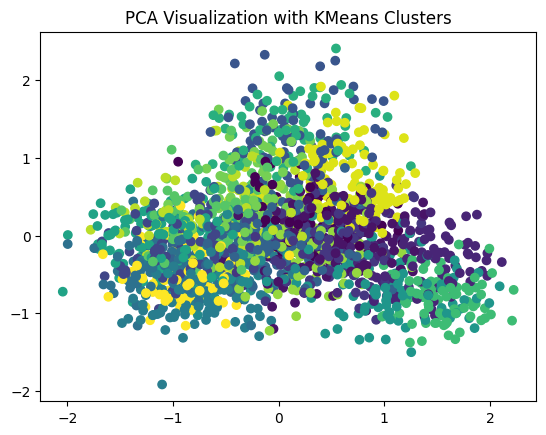

In [19]:
# Reduction de=imensions for visualisation
reduced_features = dim_red(embeddings, 2)

import matplotlib.pyplot as plt

# Plot the clusters in the reduced-dimensional space
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c = kmeans_cluster, cmap='viridis')
plt.title('PCA Visualization with KMeans Clusters')
plt.show()

### **7.2. Birch visualization**

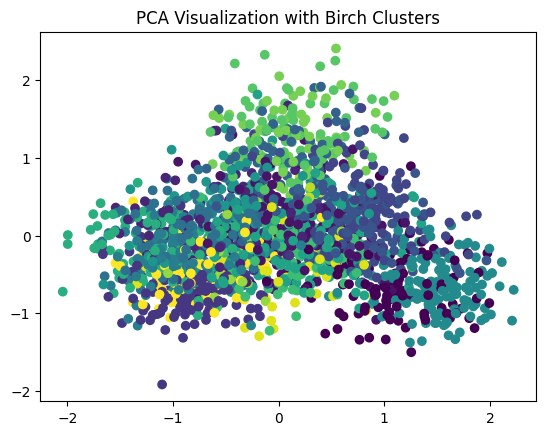

In [20]:
# Plot the clusters in the reduced-dimensional space
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c = Birch_cluster, cmap='viridis')
plt.title('PCA Visualization with Birch Clusters')
plt.show()